**Проект Яндекс.Практикума. Принятие решений в бизнесе на основе данных**

**Курс: Аналитик данных**

---



**СОДЕРЖАНИЕ**

---
[**Описание проекта**](#description)

[**Импорт библиотек и загрузка данных**](#loading)

[**Предобработка данных**](#preparing)

[**Приоритизация гипотез**](#priority)

[**Анализ A/B-теста**](#abtesting)

[**Формулировка и проверка статистических гипотез**](#hypotheses)

[**Выводы и рекомендации**](#summary)

---




## **Описание проекта**<a  class="anchor" id="description"></a>

## **Описание данных**

##  **Импорт библиотек и загрузка данных**<a  class="anchor" id="loading"></a>

In [1]:
# Загрузка библиотек
import pandas as pd
import datetime as dt

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
from scipy import stats as st
import pylab as pylab

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Функция для загрузки файлов с гугл-диска
def gdisk_gownload(link):
    url='https://drive.google.com/uc?id=' + link.split('/')[-2]
    return pd.read_csv(url)

In [3]:
# Загрузка данных
try:
    hypothesis=pd.read_csv(' ')
    orders=pd.read_csv(' ')
    visitors=pd.read_csv(' ')
except:
    hypothesis=gdisk_gownload('https://drive.google.com/file/d/ /view?usp=sharing')
    orders=gdisk_gownload('https://drive.google.com/file/d/ /view?usp=sharing')
    visitors=gdisk_gownload('https://drive.google.com/file/d/ /view?usp=sharing')

In [4]:
# устанавливаем параметры отображения данных
pd.set_option("precision", 2)
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_colwidth', 40)
pd.set_option('display.width', 120)
sns.set(style="whitegrid")



---



---




## **Предобработка данных**<a  class="anchor" id="preparing"></a>

In [5]:
# Функция для получения информации о структуре и составе данных
def check_dataset(dataset):
    try:
        print('\033[1m','Случайные 5 строк таблицы:','\033[0m')
        print(dataset.sample(n=5,random_state=43))
        print('\033[1m','\nИнформация о типах данных:', '\033[0m')
        dataset.info()
        print('\033[1m', '\nДоля пропусков в столбцах:', '\033[0m')
        print(pd.DataFrame(round((dataset.isna().mean()*100),2)))
        print('\033[1m', '\nКоличество дубликатов:', '\033[0m',dataset.duplicated().sum())
            
    except:
        print('Ошибка')

Проверка таблицы **"Гипотезы"**:

In [6]:
check_dataset(hypothesis)

 Случайные 5 строк таблицы: 
                                Hypothesis  Reach  Impact  Confidence  Efforts
3  Изменить структура категорий, что ув...      8       3           3        8
8  Запустить акцию, дающую скидку на то...      1       9           9        5
6  Показать на главной странице баннеры...      5       3           8        3
7  Добавить форму подписки на все основ...     10       7           8        5
2  Добавить блоки рекомендаций товаров ...      8       3           7        3
 
Информация о типах данных: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
 
Доля пропусков в столбцах: 
              0
Hypothesis  0.0
Reach       0.0
Impact      0.0
Confidence  0.0
Efforts     0.0
 
Количество дубликатов:  0


Таблица "Гипотезы" содержит 9 уникальных полных записей. Типы данных в таблице соотвествуют описанию.
Приведем названия столбцов таблицы "Гипотезы" к нижнему регистру.



In [7]:
hypothesis.columns=hypothesis.columns.str.lower()



---



Проверка таблицы **"Заказы"**:

In [8]:
check_dataset(orders)

 Случайные 5 строк таблицы: 
      transactionId   visitorId        date  revenue group
655      3659622247  4224378620  2019-08-07    10765     B
220      2674236505  2476105225  2019-08-23     2350     B
340       310029418  2468974761  2019-08-25     1990     B
1073     3460288289  2993711540  2019-08-12    12150     A
939      3873503306  3101956850  2019-08-08     3910     A
 
Информация о типах данных: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
 
Доля пропусков в столбцах: 
                 0
transactionId  0.0
visitorId      0.0
date           0.0
revenue        0.0
group          0.0
 
Количество дубликатов:  0


Таблица "Заказы" содержит 1197 уникальных полных записей. 
Приведем столбец "Дата" к соотвествующему типу Datetime

In [9]:
orders['date']=pd.to_datetime(orders['date'])

В случае ошибок при подготовке к тестированию, некоторые покупатели могли попасть в обе группы сразу. Выполним проверку на наличие visitorId, попавших как в группу А, так и в группу В.

In [10]:
visitorsA=orders[orders['group']=='A']['visitorId']
visitorsB=orders[orders['group']=='B']['visitorId']

In [11]:
visitorsIntersect=pd.Series(list(set(visitorsA) & set(visitorsB)))

In [12]:
print('Количество visitorID, попавших в обе группы теста: {}, что составляет {:.1%} от общего числа покупателей.'
      .format(visitorsIntersect.shape[0],visitorsIntersect.shape[0]/orders['visitorId'].nunique()))

Количество visitorID, попавших в обе группы теста: 58, что составляет 5.6% от общего числа покупателей.


Данные о заказах этих покупателей должны быть удалены из датафрейм для дальнейшего исследования.

In [13]:
orders=orders[~orders['visitorId'].isin(visitorsIntersect)]



---



Проверка таблицы **"Посетители"**:

In [14]:
check_dataset(visitors)

 Случайные 5 строк таблицы: 
          date group  visitors
52  2019-08-22     B       650
45  2019-08-15     B       544
18  2019-08-19     A       502
5   2019-08-06     A       667
37  2019-08-07     B       709
 
Информация о типах данных: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
 
Доля пропусков в столбцах: 
            0
date      0.0
group     0.0
visitors  0.0
 
Количество дубликатов:  0


Таблица "Посетители" содержит 62 уникальных полных записи. 
Приведем столбец "Дата" к соотвествующему типу Datetime

In [15]:
visitors['date']=pd.to_datetime(visitors['date'])



---



---



## **Приоритизация гипотез**<a class="anchor" id="priority"></a>

### **Применение фреймворка ICE для приоритизации гипотез**

In [16]:
hypothesis['ICE']=hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', 120)

print('\033[1m','Приоритизация гипотез по ICE','\033[0m')
hypothesis[['hypothesis','reach','impact','confidence','efforts','ICE']].sort_values(by='ICE',ascending=False).round(2)

 Приоритизация гипотез по ICE 


,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


### **Применение фреймворка RICE для приоритизации гипотез**

In [17]:
hypothesis['RICE']=hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']

print('\033[1m','Приоритизация гипотез по RICE','\033[0m')
hypothesis[['hypothesis','reach','impact','confidence','efforts','RICE']].sort_values(by='RICE',ascending=False).round(2)

 Приоритизация гипотез по RICE 


,hypothesis,reach,impact,confidence,efforts,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,3.0


При ранжировании с использованием фреймворка ICE в топ5 вышли гипотезы имеющие сочитание влияния на результат и уверенности в его достижении выше средних, при средних затратах на внедрение (мероприятия из классического, апробированного набора).

При расширении фреймворка до RICE, состав приоритетных гипотез не изменился, однако изменилось их ранжирование. На первые две позиции вышли гипотезы, имеющие наибольший потенциальный охват аудитории, несмотря на то, что они теоретически окажут не самое большое влияние на изменение метрик.



---



---



## **Анализ A/B-теста**<a class="anchor" id="abtesting"></a>

### **Рассчет кумулятивных данных**

Создадим массив уникальных пар значений дат и групп теста (datesGroups) и 
получим строки таблицы orders, дата которых меньше или равна дате элемента, а группа теста равна группе из этого массива.

Агрегируем значения из таблицы "Заказы": вычислим максимальную дату (на которую рассчитываются куммулятивные данные), число уникальных ID заказов и пользователей, сумму выручки.

In [18]:

datesGroups = orders[['date','group']].drop_duplicates()

ordersAggregated = (datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
                                     .agg({'date' : 'max', 
                                           'group' : 'max', 
                                           'transactionId' : pd.Series.nunique, 
                                           'visitorId' : pd.Series.nunique, 
                                           'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
)

Для каждой уникальной пары значений дат и групп теста получим строки таблицы visitors, дата которых меньше или равна дате элемента, а группа теста равна группе из массива datesGroups.

Агрегируем значения из таблицы "Посетители": вычислим максимальную дату (на которую рассчитываются куммулятивные данные) и число уникальных пользователей.

In [19]:
visitorsAggregated = (datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                                        .agg({'date' : 'max', 
                                              'group' : 'max', 
                                              'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])
)

Объединим обе таблицы в датафрейм cumulativeData со столбцами:

date — дата;

group — группа A/B-теста (A или B);

orders — кумулятивное количество заказов на указанную дату в указанной группе;

buyers — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;

revenue — кумулятивная выручка на указанную дату в указанной группе (средний чек);

visitors — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

In [20]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
print(cumulativeData.head(5)) 

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   142779       719
1 2019-08-01     B      17      17    59758       713
2 2019-08-02     A      42      36   234381      1338
3 2019-08-02     B      40      39   221801      1294
4 2019-08-03     A      66      60   346854      1845




---



### **График кумулятивной выручки**

Построим графики кумулятивной выручки по дням и группам A/B-тестирования. Для этого создадим датафреймы с кумулятивным количеством заказов и кумулятивной выручкой по дням в группах А и B.

In [21]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

In [22]:
def ab_metrics_plot(data1,label1,data2,label2,title,ylabel,xlabel=''):
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.plot(data1,linewidth=2, label=label1)
    ax.plot(data2,linewidth=2, label=label2)
    ax.title.set_text(title)
    ax.title.set_fontsize(20)
    ax.title.set_color('red')
    if xlabel!='':
        ax.set_xlabel(xlabel,fontsize=14)
    ax.set_ylabel(ylabel,fontsize=14)
    ax.set_facecolor('azure')
    ax.grid()
    plt.legend() 

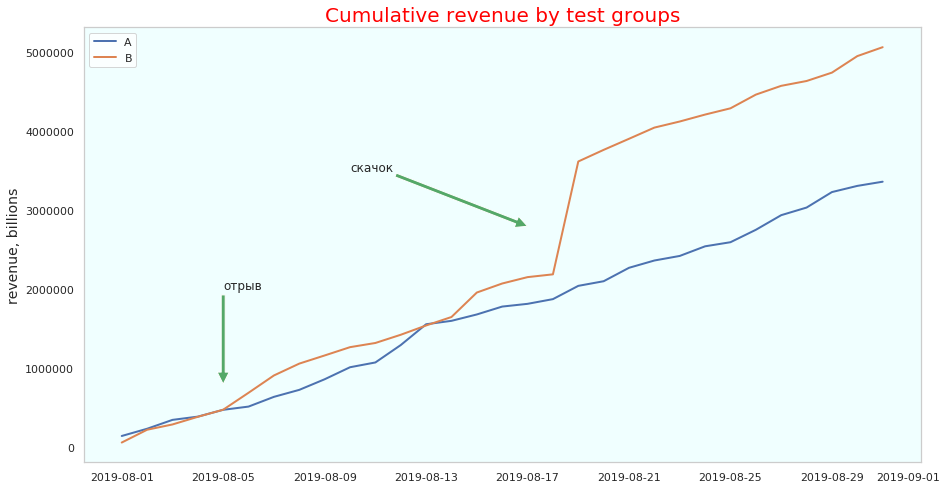

In [23]:
ab_metrics_plot(cumulativeRevenueA.set_index('date')['revenue'],'A',cumulativeRevenueB.set_index('date')['revenue'],'B','Cumulative revenue by test groups','revenue, billions',xlabel='')
plt.annotate('скачок', xy=('2019-08-17', 2800000), xytext=('2019-08-10', 3500000),
            arrowprops=dict(facecolor='g'))
plt.annotate('отрыв', xy=('2019-08-05', 800000), xytext=('2019-08-05', 2000000),
            arrowprops=dict(facecolor='g')) 
plt.show()

В начале теста куммулятивная выручка в обеих группах была примерна равной, при небольшом доминировании группы В. Через 2,5 ндели после начала теста куммулятивная выручка группы В совершила скачок, превысив выручку по группе А приблизительно на 75% (проверка на выбросы и очистка данных). К концу теста динамика выручки по обеим группам стабилизировалась. 

---



### **График среднего чека**

Построим графики среднего чека по группам (рассчитанного как отношение кумулятивной выручки к кумулятивному числу заказов).

In [24]:
cumulativeRevenueA['avg_check']=cumulativeRevenueA['revenue']/cumulativeRevenueA['orders']
cumulativeRevenueB['avg_check']=cumulativeRevenueB['revenue']/cumulativeRevenueB['orders']

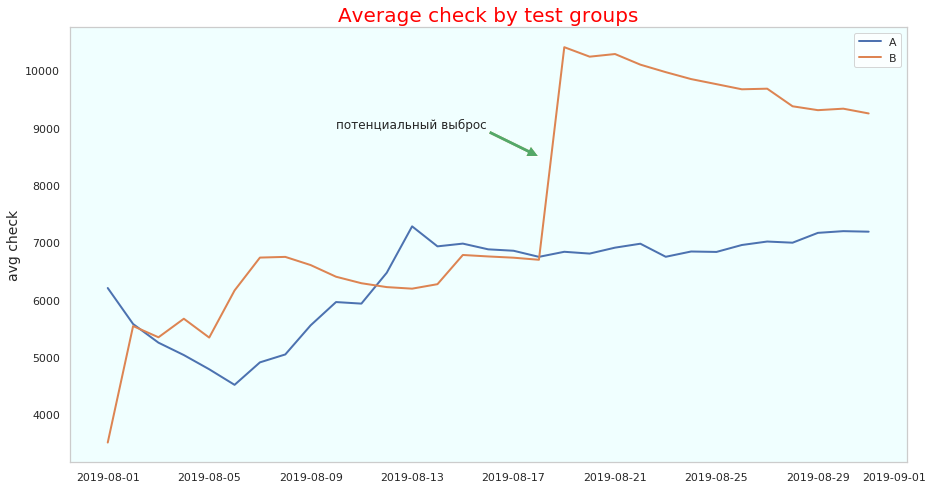

In [25]:
ab_metrics_plot(cumulativeRevenueA.set_index('date')['avg_check'],'A',cumulativeRevenueB.set_index('date')['avg_check'],'B','Average check by test groups','avg check',xlabel='')
plt.annotate('потенциальный выброс', xy=('2019-08-18', 8500), xytext=('2019-08-10', 9000),
            arrowprops=dict(facecolor='g'))
plt.show()

Средний чек тоже становится равномерным ближе к концу теста: установился для группы A и стабильно снижается для группы B. Возможно, в группу B на 2,5 неделе теста попали крупные заказы (резкий всплеск на графике). Необходимо сопоставление с графиком, построенным по гармонизировнным данным.

---



### **График относительного изменения кумулятивного среднего чека**

Построим график относительного различия для среднего чека.

In [26]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
mergedCumulativeRevenue['avg_check_rate']=mergedCumulativeRevenue['avg_checkB']/mergedCumulativeRevenue['avg_checkA']-1

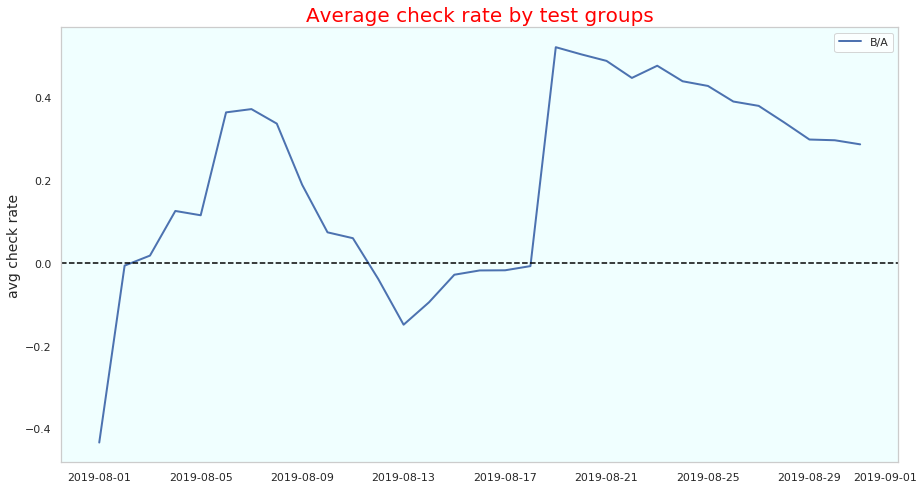

In [27]:
ab_metrics_plot(mergedCumulativeRevenue.set_index('date')['avg_check_rate'],'B/A',data2=[], label2='',title='Average check rate by test groups',ylabel='avg check rate',xlabel='')
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

Резкие смены трендов графика соотношения групповых средних чеков не позволяют однозначно определить его тенденцию. Переход к стабилизации относительного различия для среднего чека отмечется в последней трети теста. 

---



###  **График кумулятивной конверсии по группам**

Расчитаем конверсию по датафрейму кумулятивных данных и выделим из него группы.

In [28]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

Построим график кумулятивной конверсии по группам.

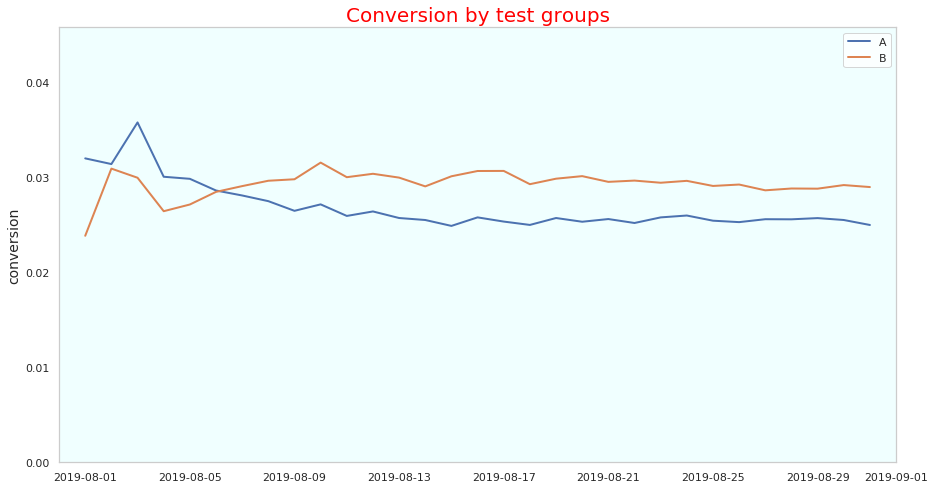

In [29]:
ab_metrics_plot(cumulativeDataA.set_index('date')['conversion'],'A',cumulativeDataB.set_index('date')['conversion'],'B','Conversion by test groups','conversion',xlabel='')
plt.axis([cumulativeData['date'].min()-dt.timedelta(days=1), cumulativeData['date'].max()+dt.timedelta(days=1), 0, cumulativeData['conversion'].max()+0.01]) 
plt.show()

Графики конверсии по тестовым группам стабильны как минимум со второй половины теста. На их основании можно сделать вывод о том, что (несмотря на общую тенденцию к снижению) конверсия по группе В стабильно превышает конверсию контрольной группы (на конец теста, визуально, на 16%, 0,029/0,025).

---



### **График относительного изменения кумулятивной конверсии**

Построим график относительного различия кумулятивных конверсий.

In [30]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
mergedCumulativeConversions['conversion_rate']=mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1

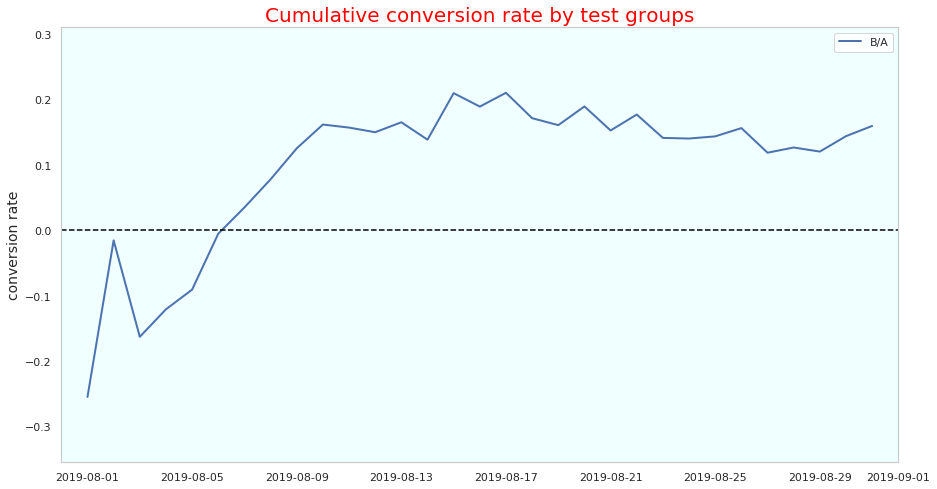

In [31]:
ab_metrics_plot(mergedCumulativeConversions.set_index('date')['conversion_rate'],'B/A',data2=[], label2='',title='Cumulative conversion rate by test groups',ylabel='conversion rate',xlabel='')
plt.axis([cumulativeData['date'].min()-dt.timedelta(days=1), cumulativeData['date'].max()+dt.timedelta(days=1), mergedCumulativeConversions['conversion_rate'].min()-0.1, mergedCumulativeConversions['conversion_rate'].max()+0.1]) 
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

График относительного изменения кумулятивной конверсии по группам подтверждает ранее сделанный вывод о превышении конверсии по группе В над данным показателем для группы А. Начиная со второй недели теста индекс конверсий по группам В/А закрепляется в положительной области и колеблется в диапазоне (+10%;+20%).

### **Анализ  количества заказов по пользователям**

Для анализа количества заказов и определения границы аномальных пользователей создадим датафрейм, в котором сгруппируем пользователей по уникальному номеру и посчитаем количество заказов.

In [32]:
ordersByUsers = (
    orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

ordersByUsers.columns = ['visitorId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

      visitorId  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


Построим гистограмму распределения количества заказов по пользователям.

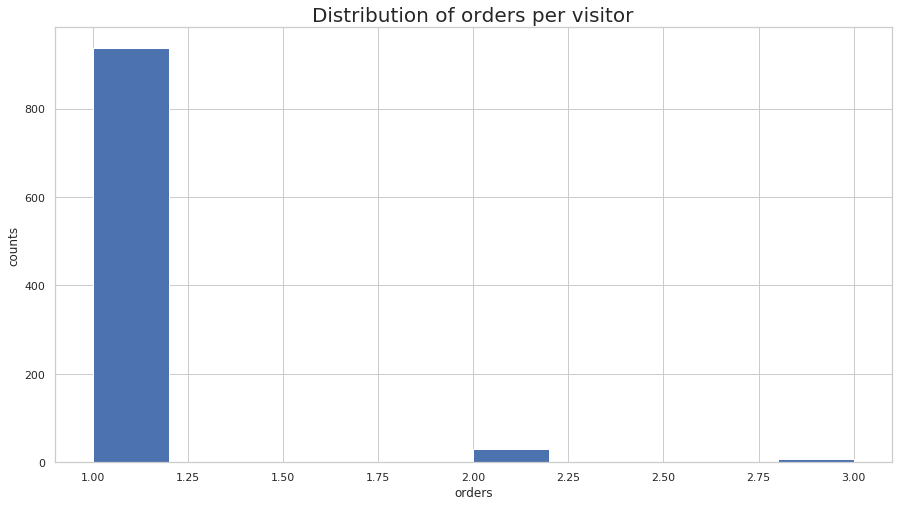

In [33]:
plt.figure(figsize=(15, 8))
plt.hist(ordersByUsers['orders'],bins=10)
plt.title('Distribution of orders per visitor',fontsize=20)
plt.xlabel('orders')
plt.ylabel('counts')
plt.show();

Гистограмма показывает, что количество заказов лежит в диапазоне "1-3".

Построим точечную диаграмму числа заказов на одного пользователя.

In [34]:
def ab_scatter(data,title,ylabel,xlabel=''):
    fig, ax = plt.subplots(figsize=(15, 8))
    plt.scatter(pd.Series(range(0,len(data))), data)
    ax.title.set_text(title)
    ax.title.set_fontsize(20)
    ax.title.set_color('red')
    if xlabel!='':
        ax.set_xlabel(xlabel,fontsize=14)
    ax.set_ylabel(ylabel,fontsize=14)
    ax.set_facecolor('azure')

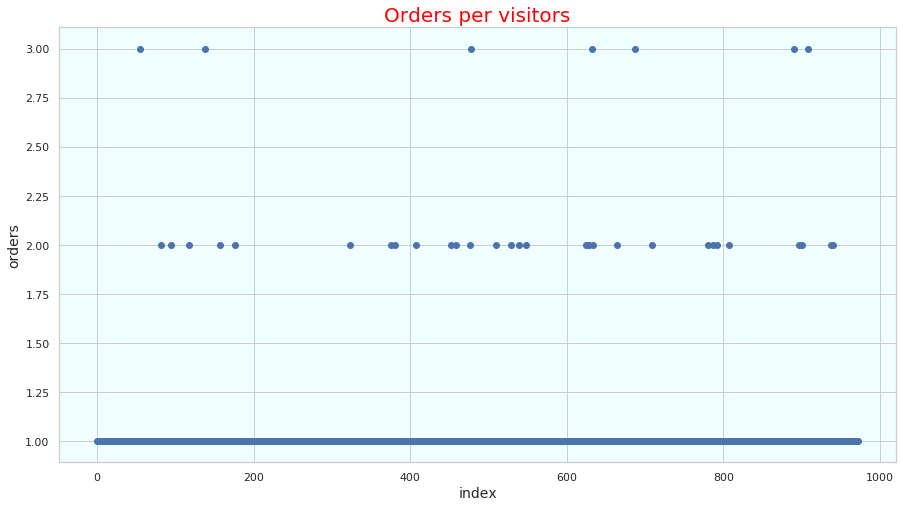

In [35]:
ab_scatter(ordersByUsers['orders'],'Orders per visitors','orders','index')

Точечная диаграмма показывает, что подавляющее большинство пользователей совершили не более 2 заказов.

Посчитаем выборочные перцентили количества заказов на одного пользователя.

In [36]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[1. 2.]


Примем количество заказов не превышающее 2х (характерно для 99% пользователей) как границу типичного поведения покупателей.

---



### **Анализ стоимостей заказов**

Стоимость половины заказов не превышает 3000 у.е., и только 25% превышают 8290 у.е. Среднее значение превышает медианное, а стандартное отклонение почти в 5 раз выше среднего, кроме того максимальное значение на несколько порядков отличается от среднего: в данных присутствуют выбросы или "жирный хвост".

In [37]:
orders['revenue'].describe().apply(lambda x: format(x, '.1f'))

count       1016.0
mean        8300.8
std        42122.0
min           50.0
25%         1190.0
50%         2955.0
75%         8134.2
max      1294500.0
Name: revenue, dtype: object

Построим точечную диаграмму стоимости заказов.

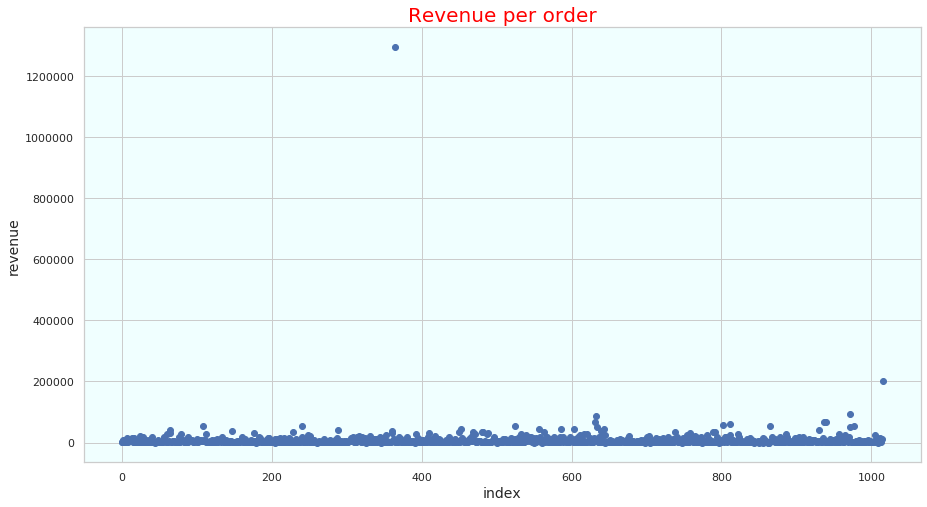

In [38]:
ab_scatter(orders['revenue'],'Revenue per order','revenue','index')

В данных присутствуют несколько выбросов превышаюших значение в 50000 у.е. Посчитаем выборочные перцентили стоимости заказов.

In [39]:
print(np.percentile(orders['revenue'], [95, 99])) 

[26785. 53904.]


Примем стоиость заказов не превышающую 26785 у.е. (характерно для 95% пользователей) как границу типичного поведения покупателей.

---



---



## **Формулировка и проверка статистических гипотез**<a  class="anchor" id="hypotheses"></a>

### **Расчет статистической значимости различий в метриках между группами по полным данным**

Оценим статистическую значимость различий **в конверсии** между группами по полным данным.

Разделим заказы по группам теста, определим общее количество посетителей по группам. Для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [40]:
visitorsAsum = visitors[visitors['group'] == 'A']['visitors'].sum()
visitorsBsum = visitors[visitors['group'] == 'B']['visitors'].sum()

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders'] 

Создадим выборки A и B, состоящие из списка с количеством заказов для каждого из пользователей, совершивших заказ, и нулей для пользователей, которые ничего не заказывали.

In [41]:
sampleA = (pd.concat([ordersByUsersA['orders'],
                     pd.Series(0,index=np.arange(visitorsAsum - len(ordersByUsersA['orders'])),
                    name='orders')],axis=0))

sampleB = (pd.concat([ordersByUsersB['orders'],
                     pd.Series(0,index=np.arange(visitorsBsum - len(ordersByUsersB['orders'])),
                    name='orders')],axis=0))

Для выбора критерия оценки статистической значимости (t-критерия Стюарта или Манна-Уитни) различий в конверсии между группами по полным данным проверим выборки на нормальность распределения данных в самих выборках и t-статистики выборок.
Применим функцию, проверяющую гипотезу о нормальном распределении данных (строящую для данных графики распределения вероятностей (Q-Q plot) и проводящую тест Шапиро-Вилка).

In [42]:
def distribution_normality_check(data1,data2,n=10000,s=0.1,alpha=0.001):

    def set_titles(ax,title):
        ax.set_title(title)
        ax.title.set_color('black')
        ax.title.set_size(14)

    sample_size=round(min(len(data1),len(data2))*s)
    result=[]
    for _ in range(n):
        result.append(st.ttest_ind(np.random.choice(np.array(data1),size=sample_size,replace=False),np.random.choice(np.array(data2),size=sample_size,replace=False)).statistic)

    plt.figure(figsize=(21,7))    
    ax1 = plt.subplot2grid((3, 3), (0, 0),rowspan=2)
    st.probplot(data1, dist="norm", plot=plt, rvalue=True)
    set_titles(ax1,'Proximity to the normal distribution (red line) of first sample')
    ax2 = plt.subplot2grid((3, 3), (0, 1),rowspan=2)
    st.probplot(data2, dist="norm", plot=plt,rvalue=True)
    set_titles(ax2,'Proximity to the normal distribution (red line) of second sample')
    ax3 = plt.subplot2grid((3, 3), (0, 2),rowspan=2)
    st.probplot(result, dist="norm", plot=plt,rvalue=True)
    set_titles(ax3,'Proximity to the normal distribution (red line) of t-statistics')
   
    def shapiro_test(data):
        x,y = st.shapiro(data)
        p_value=format(y,'.8f')
        if (y < alpha):
            verdict='Normal distribution of data: rejected'
            passed='no'
        else:
            verdict='Normal distribution of data: not rejected'
            passed='yes'
        return ['p-value = '+p_value+'\n'+verdict,passed]
   
    def plt_text(ax,text,passed):
        if passed=='yes':
            color='green'
        else:
            color='tab:red'
        ax.text(0.5,0.5,text,fontsize='x-large',horizontalalignment='center',verticalalignment='center',linespacing=2,c=color) 
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')
    
    ax4 = plt.subplot2grid((3, 3), (2, 0))
    test_res=shapiro_test(data1)
    text='Shapiro–Wilk test for first sample:\n'+test_res[0]
    plt_text(ax4,text,test_res[1])
    
    ax5 = plt.subplot2grid((3, 3), (2, 1))
    test_res=shapiro_test(data2)
    text='Shapiro–Wilk test for second sample:\n'+test_res[0]
    plt_text(ax5,text,test_res[1])

    ax6 = plt.subplot2grid((3, 3), (2, 2))
    test_res=shapiro_test(result)
    text='Shapiro–Wilk test for t-statistics:\n'+test_res[0]
    plt_text(ax6,text,test_res[1])

    plt.tight_layout()
    plt.show() 

Сформулируем нулевую гипотезу: данные в выборках А и В распределены нормально и  для оценки статистической значимости различий в их средних может быть использован дисперсионный анализ или t-критерий Стюарта.
Соотвественно, альтернативной гипотезой будет: распределение данных в выборках А и В отличается от нормального и для оценки статистической значимости различий в их средних следует использовать критерий Манна-Уитни.

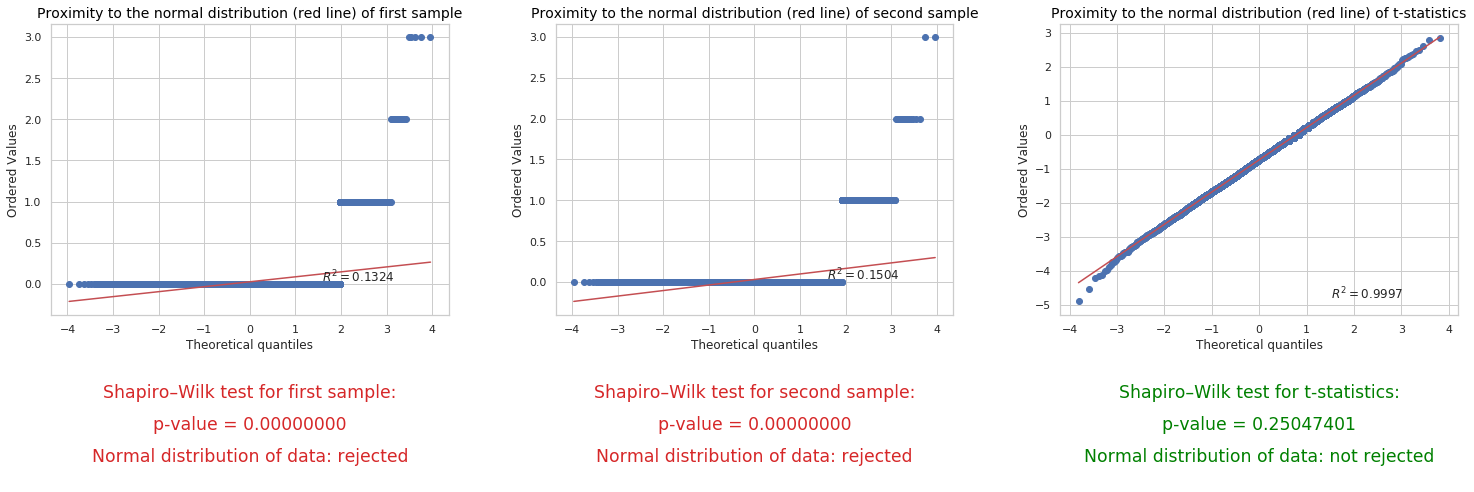

In [43]:
distribution_normality_check(sampleA,sampleB,n=10000,s=0.1,alpha=0.001)

Отвергаем гипотезу о нормальности распределания данных. 

Для проверки нулевой гипотезы о том, что нет никаких различий в средних значениях конверсии для групп А и B, применим критерий Манна-Уитни. Пороговый уровень значимости примем в 5% (alpha=0.05). 
Альтернативной гипотезой считаем: средние значения конверсии для групп А и Б отличаются.

In [44]:
print("p-value: {0:.3f}".format(st.mannwhitneyu(sampleA, sampleB, alternative="two-sided")[1]))

p-value: 0.011


Вероятность получить подобные или еще более выраженные отклонения средних из этих двух выборок при условии верности нулевой гипотезы превышает пороговое значение уровня значимости.

**Вывод:** не отвергаем нулевую гипотезу. Нельзя утверждать, что средняя конверсия по группе покупателей А отличается от средней конверсии по группе покупателей В.

In [45]:
print("Относительный прирост конверсии группы B: {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

Относительный прирост конверсии группы B: 0.160


Результаты расчета отностительного прироста конверсии группы В к А, проведенные по полным данным, укладываются в ранее сделанное пердположение об индексе конверсий в 1,16.



---



Оценим статистическую значимость различий **в среднем чеке** между группами по полным данным.

Создадим выборки A и B, состоящие из данных о выручке с заказов по группам теста.

In [46]:
sampleA=orders[orders['group']=='A']['revenue']
sampleB=orders[orders['group']=='B']['revenue']

Для выбора критерия оценки статистической значимости (t-критерия Стюарта или Манна-Уитни) различий в среднем чеке между группами по полным данным проверим выборки на нормальность распределения данных в самих выборках и t-статистики выборок.

Сформулируем нулевую гипотезу: данные в выборках А и В распределены нормально и  для оценки статистической значимости различий в их средних может быть использован дисперсионный анализ или t-критерий Стюарта.
Соотвественно, альтернативной гипотезой будет: распределение данных в выборках А и В отличается от нормального и для оценки статистической значимости различий в их средних следует использовать критерий Манна-Уитни.

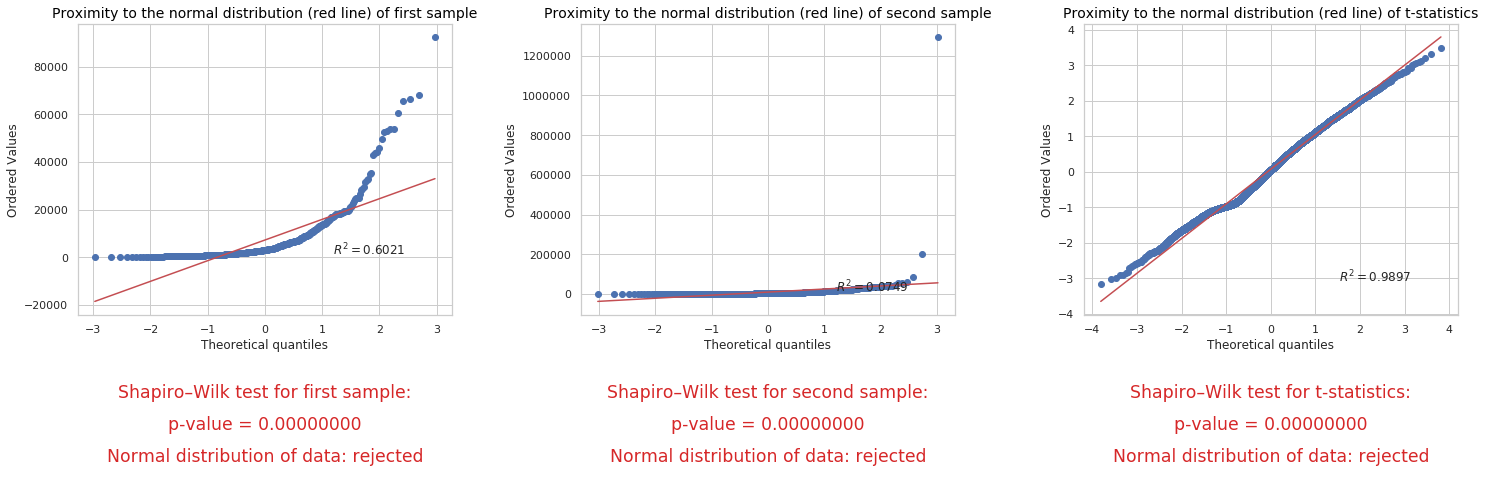

In [47]:
distribution_normality_check(sampleA,sampleB,n=10000,s=0.1,alpha=0.001)

Отвергаем гипотезу о нормальности распределания данных. 

Для проверки нулевой гипотезы о том, что нет никаких различий в средних значениях чека для групп А и B, применим критерий Манна-Уитни. Пороговый уровень значимости примем в 5% (alpha=0.05). 
Альтернативной гипотезой считаем: значения среднего чека для групп А и Б отличаются.

In [48]:
print("p-value: {0:.3f}".format(st.mannwhitneyu(sampleA, sampleB, alternative="two-sided")[1]))

p-value: 0.829


**Вывод:** не отвергаем нулевую гипотезу. Нельзя утверждать, что средний чек по группе покупателей А отличается от среднего чека по группе покупателей В.

In [49]:
print('Относительные различия в среднем чеке между группами: {0:.3f}'.format(sampleB.mean()/sampleA.mean()-1)) 

Относительные различия в среднем чеке между группами: 0.287


Ввиду того, что показатель среднего чека, рассчитанный по полным данным, подвержен флуктуациям и визуально не коррелирует для групп, данные об относительном различии метрики непригодны для вывода о доминировании группы В.

---



### **Расчет статистической значимости различий в метриках между группами по "очищенным" данным**

Примем за аномальных пользователей тех, кто совершил от 3 заказов или совершил заказ дороже 26 785 у.е. 

Сделаем срезы пользователей с числом заказов больше 2 — usersWithManyOrders и пользователей, совершивших заказы дороже 26 785 — usersWithExpensiveOrders.

In [50]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],
                                 ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId']],axis=0)
usersWithExpensiveOrders = orders[orders['revenue'] > 26785]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates().sort_values()

print('К исключению {0:.1%} ID покупателей'.format(abnormalUsers.shape[0]/orders.visitorId.count())) 

К исключению 5.7% ID покупателей


Создадим выборки, разделенные по группам теста, очищенные от данных "аномальных" покупателей.

In [51]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],
                             pd.Series(0,index=np.arange(visitorsAsum - len(ordersByUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],
                             pd.Series(0,index=np.arange(visitorsBsum - len(ordersByUsersB['orders'])),name='orders')],axis=0) 

Для выбора критерия оценки статистической значимости (t-критерия Стюарта или Манна-Уитни) различий в **конверсии** между группами по "очищенным" данным проверим выборки на нормальность распределения данных в самих выборках и t-статистики выборок.

Сформулируем нулевую гипотезу: данные в выборках А и В распределены нормально и  для оценки статистической значимости различий в их средних может быть использован дисперсионный анализ или t-критерий Стюарта.
Соотвественно, альтернативной гипотезой будет: распределение данных в выборках А и В отличается от нормального и для оценки статистической значимости различий в их средних следует использовать критерий Манна-Уитни.

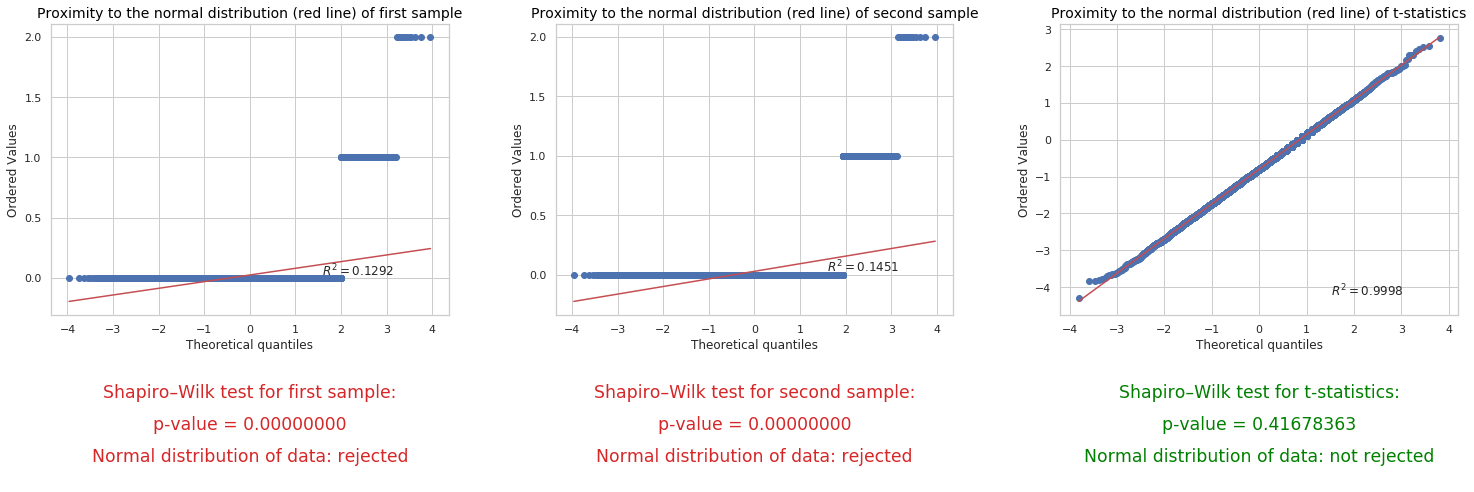

In [52]:
distribution_normality_check(sampleAFiltered,sampleBFiltered,n=10000,s=0.1,alpha=0.001)

Отвергаем гипотезу о нормальности распределания данных. 

Для проверки нулевой гипотезы о том, что нет никаких различий в средних значениях конверсии для групп А и B, применим критерий Манна-Уитни. Пороговый уровень значимости примем в 5% (alpha=0.05). 
Альтернативной гипотезой считаем: средние значения конверсии для групп А и Б отличаются.

In [53]:
print("p-value: {0:.3f}".format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative="two-sided")[1]))

p-value: 0.012


Вероятность получить подобные или еще более выраженные отклонения средних из этих двух выборок при условии верности нулевой гипотезы не превышает пороговое значение уровня значимости.

**Вывод:** отвергаем нулевую гипотезу. Нельзя утверждать, что средняя конверсия рассчитанная по "очищенным" данным по группе покупателей А не отличается от средней конверсии по группе покупателей В, определенной подобным образом.

In [54]:
print("Относительный прирост конверсии группы B: {0:.3f}".format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

Относительный прирост конверсии группы B: 0.182


Очищенные данные дают информацию о еще более значительном превышении конверсии по группе В над показателем тестовой группы.



---



Оценим статистическую значимость различий **в среднем чеке** между группами по "очищенным" данным.

Создадим выборки A и B, состоящие из данных о выручке с заказов по группам теста, очищенные от данных "аномальных" покупателей.

In [55]:
sampleAFiltered=orders[np.logical_and(orders['group'] == 'A',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue']
sampleBFiltered=orders[np.logical_and(orders['group'] == 'B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue']

Для выбора критерия оценки статистической значимости (t-критерия Стюарта или Манна-Уитни) различий в среднем чеке между группами по "очищенным" данным проверим выборки на нормальность распределения данных в самих выборках и t-статистики выборок.

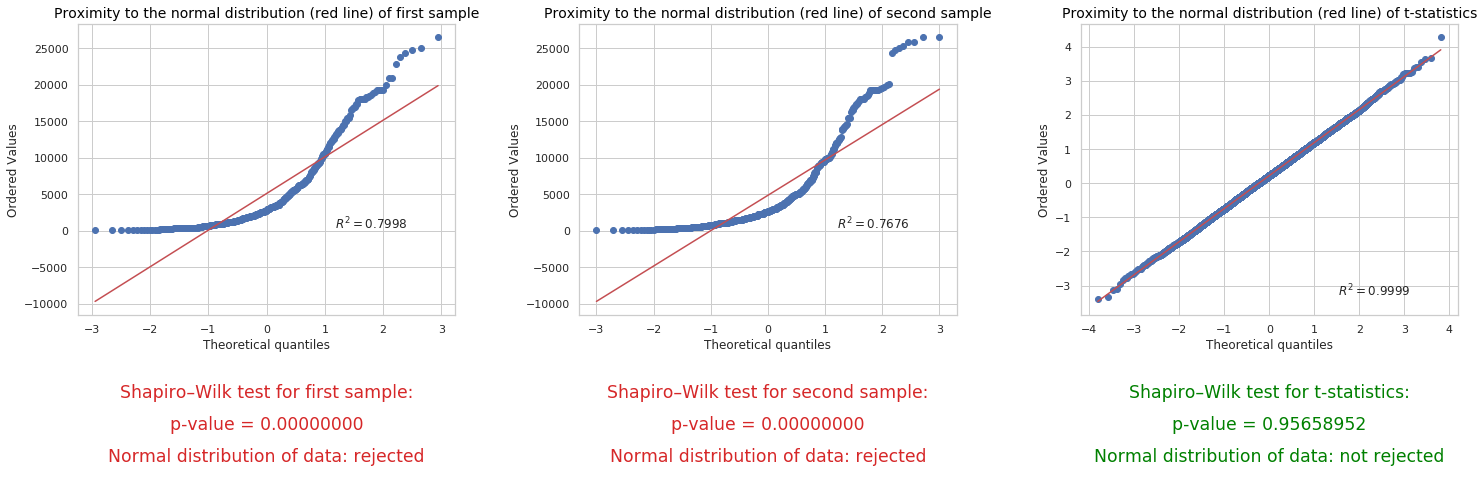

In [56]:
distribution_normality_check(sampleAFiltered,sampleBFiltered,n=10000,s=0.1,alpha=0.001)

Отвергаем гипотезу о нормальности распределания данных. 

Для проверки нулевой гипотезы о том, что нет никаких различий в средних значениях чека, рассчитанных по "очищенным" данным, для групп А и B, применим критерий Манна-Уитни. Пороговый уровень значимости примем в 5% (alpha=0.05). 
Альтернативной гипотезой считаем: значения среднего чека для групп А и Б отличаются.

In [57]:
print("p-value: {0:.3f}".format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative="two-sided")[1]))

p-value: 0.646


**Вывод:** не отвергаем нулевую гипотезу. Нельзя утверждать, что средний чек по группе покупателей А отличается от среднего чека по группе покупателей В, для метрик, рассчитанных по "очищенным" данным.

In [58]:
print('Относительные различия в среднем чеке между группами: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

Относительные различия в среднем чеке между группами: -0.048


Гармонизированные данные не устраняют волатильность метрики среднего чека полностью, однако индекс относительного различия показателя приблизился к 0. Возможно, нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне. 

---



### **Подготовка к интерпретации результатов теста**

Рассчитаем кумулятивные данные по "очищенным" датафреймам.

In [59]:
filtered_orders=orders[~orders['visitorId'].isin(abnormalUsers)]
filtered_ordersAgg = (datesGroups.apply(lambda x: filtered_orders[np.logical_and(filtered_orders['date'] <= x['date'], filtered_orders['group'] == x['group'])]
                                     .agg({'date' : 'max', 
                                           'group' : 'max', 
                                           'transactionId' : pd.Series.nunique, 
                                           'visitorId' : pd.Series.nunique, 
                                           'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
)
filtered_ordersAgg.columns = ['date', 'group', 'orders', 'buyers', 'revenue']
cumRevAfiltered = filtered_ordersAgg[filtered_ordersAgg['group']=='A'][['date','revenue', 'orders']]
cumRevBfiltered = filtered_ordersAgg[filtered_ordersAgg['group']=='B'][['date','revenue', 'orders']]
cumRevAfiltered['avg_check']=cumRevAfiltered['revenue']/cumRevAfiltered['orders']
cumRevBfiltered['avg_check']=cumRevBfiltered['revenue']/cumRevBfiltered['orders']
mergedCumRevFiltered = cumRevAfiltered.merge(cumRevBfiltered, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
mergedCumRevFiltered['avg_check_rate']=mergedCumRevFiltered['avg_checkB']/mergedCumRevFiltered['avg_checkA']-1

Построим график куммулятивной конверсии по "очищенным" данным.

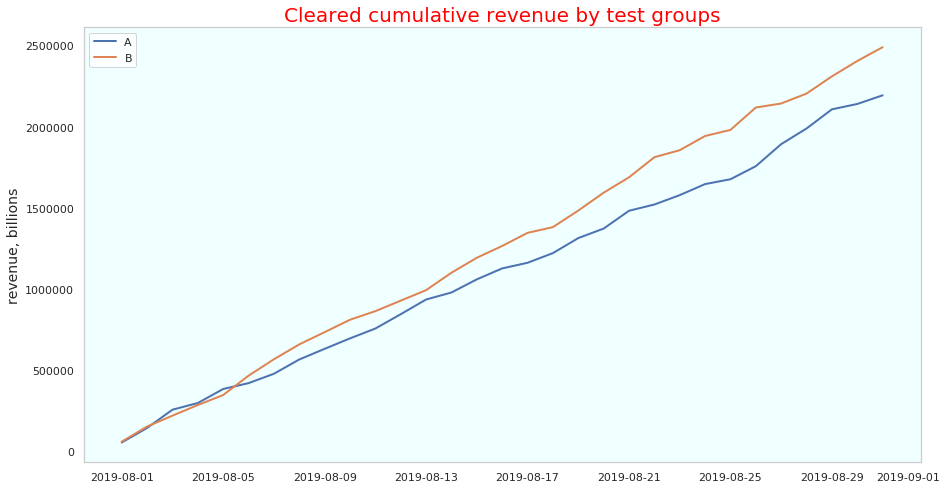

In [60]:
ab_metrics_plot(cumRevAfiltered.set_index('date')['revenue'],'A',cumRevBfiltered.set_index('date')['revenue'],'B','Cleared cumulative revenue by test groups','revenue, billions',xlabel='')
plt.show()

Построим графики среднего чека и его относительного изменения по группам не основе "очищенных" данных.

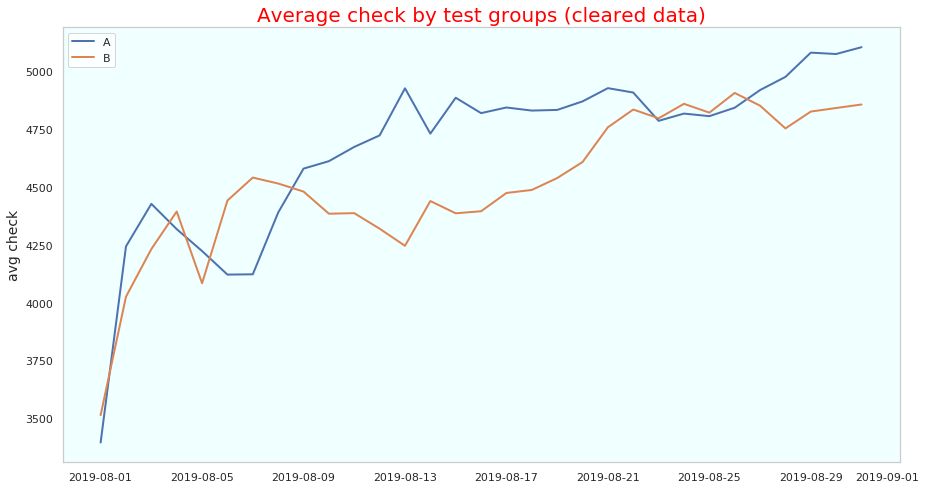

In [61]:
ab_metrics_plot(cumRevAfiltered.set_index('date')['avg_check'],'A',cumRevBfiltered.set_index('date')['avg_check'],'B','Average check by test groups (cleared data)','avg check',xlabel='')
plt.show()

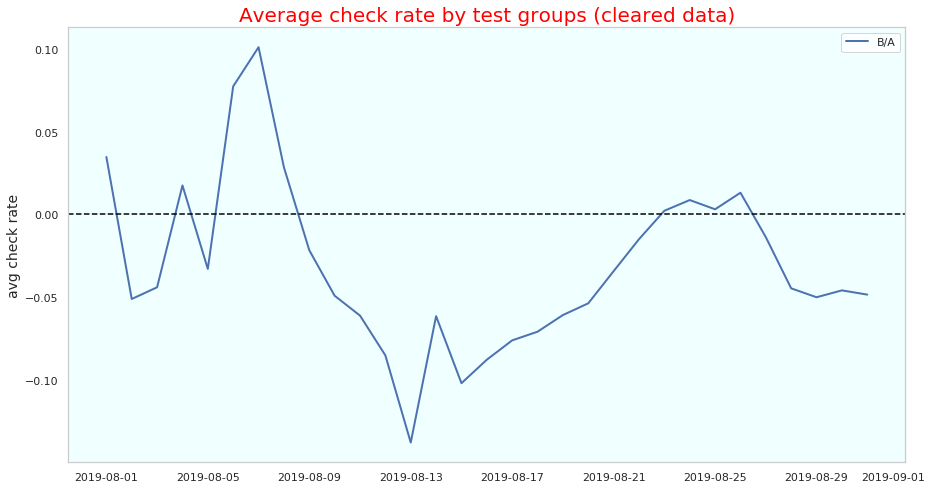

In [62]:
ab_metrics_plot(mergedCumRevFiltered.set_index('date')['avg_check_rate'],'B/A',data2=[], label2='',title='Average check rate by test groups (cleared data)',ylabel='avg check rate',xlabel='')
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

In [63]:
visitorsA=orders[orders['group']=='A']['visitorId']
print('Размер выборки А: {}'.format(visitorsA.count()))

Размер выборки А: 468


In [64]:
visitorsB=orders[orders['group']=='B']['visitorId']
print('Размер выборки В: {}'.format(visitorsB.count()))

Размер выборки В: 548


## **Анализ результатов теста**

Результаты теста демонстрируют наличие статистически значимого различия по куммулятивной выручке между группами по данным после фильтрации аномалий. Выручка по группе В стабильно превышает контрольную группу на 13,6%.

Анализ среднего чека статистически значимого различия между группами не выявил ни по «сырым», ни по данным после фильтрации аномалий. 

График различия конверсии между группами сообщает, что результаты группы B лучше группы A в динамике на 10-20%.

График различия среднего чека, построенный по "очищенным" данным, говорит о том, что отсутствует сформировавшаяся тенднция показателя и для выводов не хватает данных.

***Вывод:***

Несмотря на положительную динамику, тест следует продолжить до достижения выборками размера в 850-870 записей (рассчитанный объем выборки при разнице в конверсии в 16% при минимальном эффекте в 5%) для оценки наличия статистически значимого различия групповых метрик. 

## **Выводы и рекомендации**<a  class="anchor" id="summary"></a>

В данном проекте мы провели ранжирование подготовленных отделом маркетинга гипотез и выявили наиболее приоритетные по совокупности потенциального воздействия на метрики, уверенности в достижении эффекта и охвату аудитории при известных затратах на реализацию мероприятий.
В список наиболее приоритетных вошли:
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
- Запустить акцию, дающую скидку на товар в день рождения.

Проведенный в течение месяца А/В тест продемонстрировал положительную динамику эффекта группы, на которой проверяется гипотеза, по сравнению с контрольной группой. Однако, в связи с тем, что статистическая значимость достигнутого эффекта подтверждена не для всех ключевых метрик, проведение теста следует продолжить еще на 2 недели до достижения выборками групп А и В расчетного объема.
